In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from skimage.io import imshow
#from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras

from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
#making sure GPU is in use 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6220596027286645708
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11285289370
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2075468616681951315
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
# Set some parameters
in_height = 64
in_width = 64
out_height = 256
out_width = 256
color_dim = 3
path_in = '/home/Matthew/image-super-resolution/data/imagenet/10k/res64/'
path_out = '/home/Matthew/image-super-resolution/data/imagenet/10k/res256/'

In [4]:
#todo: add random shuffle 
#, seed = 0

def load_images(path_in, path_out, test_size):
    images = next(os.walk(path_in))[2] #oswalk is a generator 
    num_images = len(images)

    splitIdx = int(test_size * num_images)
    testSize = int((test_size) * num_images)
    trainSize = int(math.ceil((1-test_size) * num_images))
    
    X_train = np.zeros((trainSize,in_height,in_width,color_dim), dtype=np.float32)
    X_test = np.zeros((testSize,in_height,in_width,color_dim), dtype=np.float32)
    y_train = np.zeros((trainSize,out_height,out_width,color_dim), dtype=np.float32)
    y_test  = np.zeros((testSize,out_height,out_width,color_dim), dtype=np.float32)

    trainIdx = 0
    testIdx = 0
    for idx, image in enumerate(images):
        image_in_path = os.path.join(path_in,image)
        image_out_path = os.path.join(path_out,image)

        image_in_raw =  load_img(image_in_path, grayscale=False)
        image_out_raw = load_img(image_out_path, grayscale=False)

        #converts image to keras preprocessing image, then divide by 255 to un-invert the images
        image_in = (img_to_array(image_in_raw)).squeeze() / 255 
        image_out = (img_to_array(image_out_raw)).squeeze() / 255          
 
        try:
            if (idx % 1000 == 0):
                print("Stage " + str(idx))
        
            if (idx >= splitIdx):
                #print("trainIdx " + str(trainIdx))
                X_train[trainIdx] = image_in
                y_train[trainIdx] = image_out
                
                trainIdx+=1
            else:
                #print("testIdx " + str(testIdx))
                X_test[testIdx] = image_in
                y_test[testIdx] = image_out
                
                testIdx+=1
                
        except Exception as e: 
            print("\nERROR!!!!")
            print(image_in.shape)
            print(trainIdx)
            
            print(image_out.shape)
            print(testIdx)
            
            print("id "+str(idx))
            print(image_in_path)
            print(e)
           
            print("\n")
            
    return X_train,X_test,y_train,y_test

In [5]:
X_train,X_test,y_train,y_test = load_images(path_in, path_out, .2)

Stage 0
Stage 1000
Stage 2000
Stage 3000
Stage 4000
Stage 5000
Stage 6000
Stage 7000
Stage 8000
Stage 9000


In [6]:
def PrintRandomImages(X,y,numItr,seed=0):
    random.seed(seed)
    for _ in range(0,numItr):
        randImage = random.randint(0,len(X))
        plt.imshow(X[randImage])
        plt.show()
        plt.imshow(y[randImage])
        plt.show()

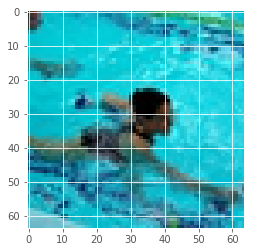

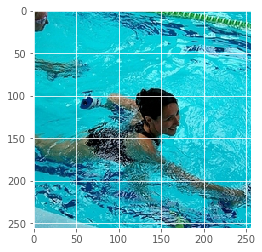

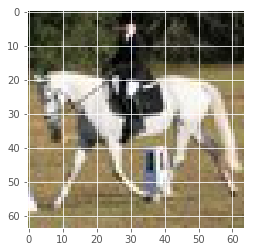

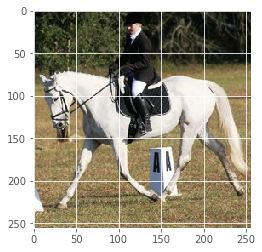

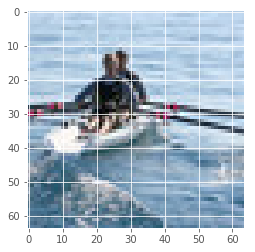

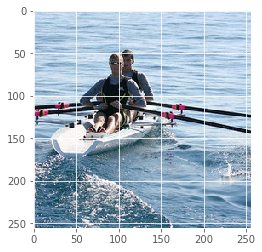

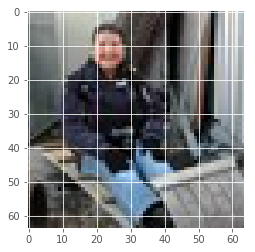

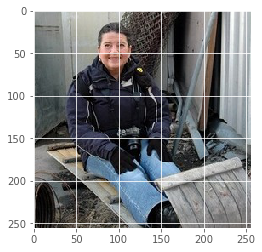

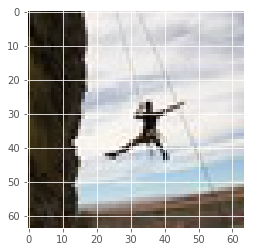

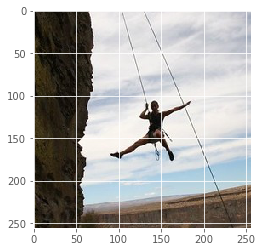

In [7]:
PrintRandomImages(X_train,y_train,5,23)

In [8]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D
from keras.optimizers import RMSprop

In [9]:
model = Sequential()
inputShape = (in_height, in_width, color_dim)

#encoder
#model.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape = inputShape)) # 64 x 64 x 32)
#model.add(MaxPooling2D(pool_size=(2, 2))) # 32 x 32 x 32
#model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) #32 x 32 x 64
#model.add(MaxPooling2D(pool_size=(2, 2))) # 16 x 16 x 64
#model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) # 16 x 16 x 128 (small and thick)

#decoder


#model.add(Conv2D(512, (3, 3), activation='relu', padding='same',input_shape = inputShape)) # 64 x 64 x 512)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',input_shape = inputShape)) # 64 x 64 x 256)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) # 64 x 64 x 128)
model.add(UpSampling2D((2,2))) # 128 x 128 x 128
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # 128 x 128 x 64)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) # 128 x 128 x 32)
model.add(Conv2D(16, (3, 3), activation='relu', padding='same')) # 128 x 128 x 16)
model.add(UpSampling2D((2,2))) # 256 x 256 x 16
model.add(Conv2D(8, (3, 3), activation='relu', padding='same')) # 256 x 256 x 8)
model.add(Conv2D(4, (3, 3), activation='relu', padding='same')) # 256 x 256 x 4)
model.add(Conv2D(4, (3, 3), activation='relu', padding='same')) # 256 x 256 x 4)
model.add(Conv2D(3, (3, 3), activation='relu', padding='same')) # 256 x 256 x 3)
model.add(Conv2D(3, (3, 3), activation='relu', padding='same')) # 256 x 256 x 3)
model.add(Conv2D(3, (3, 3), activation='relu', padding='same')) # 256 x 256 x 3)

In [10]:
model.compile(loss='mean_squared_error', optimizer = RMSprop())

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 256)       7168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 16)      4624      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 256, 256, 16)      0         
__________

In [12]:
#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [13]:
#session.close()

In [14]:
batch_size = 256
epochs = 25

trainHistory = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

Train on 8000 samples, validate on 2000 samples
Epoch 1/25
8000/8000 [==============================] - 155s 19ms/step - loss: 0.4443 - val_loss: 0.0676
Epoch 2/25
8000/8000 [==============================] - 124s 16ms/step - loss: 0.0436 - val_loss: 0.0509
Epoch 3/25
8000/8000 [==============================] - 124s 15ms/step - loss: 0.0528 - val_loss: 0.0350
Epoch 4/25
8000/8000 [==============================] - 124s 15ms/step - loss: 0.0509 - val_loss: 0.0268
Epoch 5/25
8000/8000 [==============================] - 124s 15ms/step - loss: 0.0437 - val_loss: 0.0264
Epoch 6/25
8000/8000 [==============================] - 124s 16ms/step - loss: 0.0410 - val_loss: 0.0320
Epoch 7/25
8000/8000 [==============================] - 123s 15ms/step - loss: 0.0370 - val_loss: 0.0348
Epoch 8/25
8000/8000 [==============================] - 124s 15ms/step - loss: 0.0348 - val_loss: 0.0264
Epoch 9/25
8000/8000 [==============================] - 124s 16ms/step - loss: 0.0327 - val_loss: 0.0266
Epoch 1

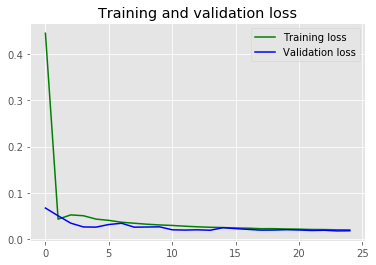

In [27]:
loss = trainHistory.history['loss']
val_loss = trainHistory.history['val_loss']
epochsRange = range(epochs)
plt.figure()
plt.plot(epochsRange, loss, label='Training loss',color='g')
plt.plot(epochsRange, val_loss, label='Validation loss',color='b')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
#predicting (overfit)

In [29]:
pred = model.predict(X_test)

In [30]:
pred.shape

(2000, 256, 256, 3)

Test Images


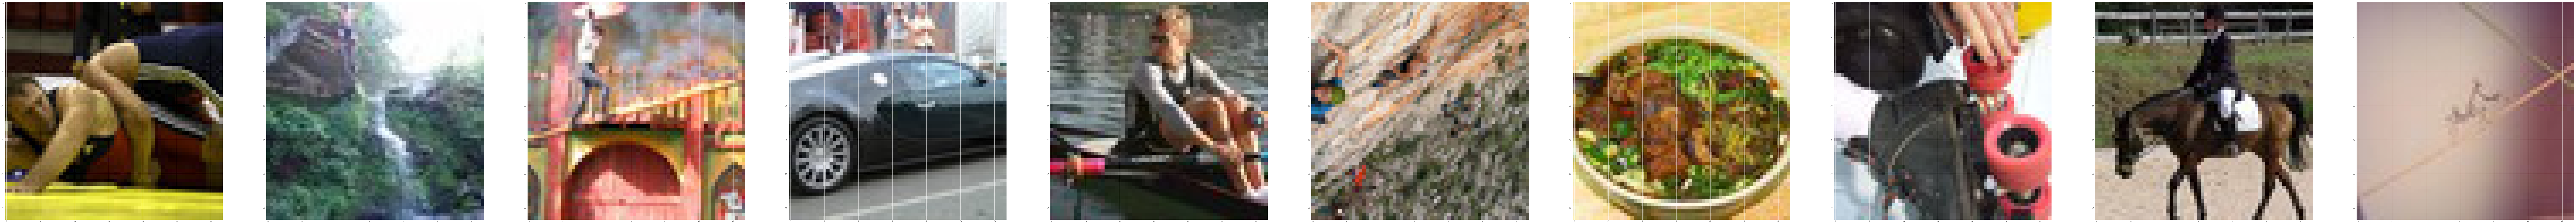

Reconstruction of Test Images


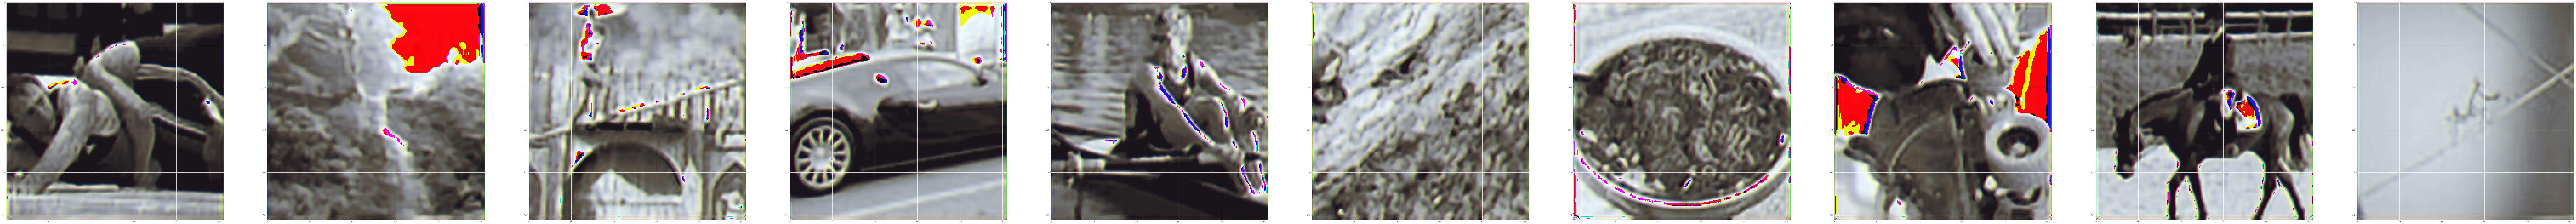

In [35]:
plt.figure(figsize=(256, 256))
print("Test Images")

for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i])
    curr_lbl = y_test[i]
    #plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()
plt.figure(figsize=(256, 256))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i])  
plt.show()

In [ ]:
'''# initialize the model
model = Sequential()
inputShape = (in_height, in_width, color_dim)

''if K.image_data_format() == "channels_first":
    print('Channels first')
    inputShape = (color_dim, in_height, in_width)
 
# the entire SRCNN architecture consists of three CONV => RELU layers with *no* zero-padding
model.add(Conv2D(64, (9, 9), activation='relu', input_shape=inputShape))
model.add(Conv2D(32, (1, 1), activation='relu', kernel_initializer="he_normal"))
model.add(Conv2D(color_dim, (5, 5), activation='relu', kernel_initializer="he_normal"))'''''

In [ ]:
'''opt = Adam(lr=0.001, decay=0.001 / 10)
model.compile(loss="mse", optimizer=opt)'''

In [ ]:
'''
with open('res50t0res250.pickle', 'wb') as handle:
    pickle.dump((X_train,X_test,y_train,y_test), handle, protocol=pickle.HIGHEST_PROTOCOL)'''

In [ ]:
'''with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

print a == b'''